In [ ]:
import math
import random
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return action

In [ ]:
class StateNormalization(object):
    def __init__(self):
        env = UAVEnv()
        M = env.M
        self.high_state = np.array(
            [5e7, env.ground_length, env.ground_width, 100000 * 1048576])
        self.high_state = np.append(self.high_state, np.ones(M * 2) * env.ground_length)
        self.high_state = np.append(self.high_state, np.ones(M) * 100000 * 1048576)
        self.low_state = np.zeros(3 * M + 4)  # uav loc, ue loc, task size, block_flag

    def state_normal(self, state):
        return state / (self.high_state - self.low_state)

In [ ]:
def plot(i, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (i, rewards[-1]))
    plt.plot(rewards)
    plt.show()

def plotAvg(i, rewards):
    res = []
    for i in range(int(i/50)):
        res.append(np.array(average_delay[i*50:i*50+50]).mean())
    plt.plot(res)
    plt.xlabel('epochs/50')
    plt.ylabel('Average Time Delay')

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim[0])
        self.linear2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.linear3 = nn.Linear(hidden_dim[1], hidden_dim[2])
        self.linear4 = nn.Linear(hidden_dim[2], 1)
        
        self.linear4.weight.data.uniform_(-init_w, init_w)
        self.linear4.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [ ]:
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size[0])
        self.linear2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.linear4 = nn.Linear(hidden_size[2], 1)
        
        self.linear4.weight.data.uniform_(-init_w, init_w)
        self.linear4.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size[0])
        self.linear2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear3 = nn.Linear(hidden_size[1], hidden_size[2])
        
        self.mean_linear = nn.Linear(hidden_size[2], num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size[2], num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

In [ ]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())

    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step() 

# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

In [ ]:
class UAVEnv(object):
  
    height = ground_length = ground_width = 100
    SUM_TASK_SIZE = curr_sum_task_size = 300 * 1048576    # Total computing tasks 500 Mbits
    loc_uav = [50, 50]
    bandwidth_nums = 1
    B = bandwidth_nums * 10 ** 6                          # Bandwidth 1MHz
    p_noisy_los = 10 ** (-13)                             # Noise power -100dBm
    p_noisy_nlos = 10 ** (-11)                            # Noise power -80dBm
    flight_speed = 50.                                    # Flight speed 50m/s
    f_ue = 6e8                                            # UE computing frequency : 0.6GHz
    f_uav = 6e9                                           # UAV computing frequency : 1.2GHz
    r = 10 ** (-27)        
    s = 1000                                              # number of cpu cycles required for unit bit processing is 1000
    p_uplink = 0.1                                        # Uplink transmission power 0.1W
    alpha0 = 1e-5                                         # Reference channel gain at 1m distance -30dB = 0.001, -50dB = 1e-5
    v_ue = 1                                              # ue moving speed 1m/s
    t_fly = 1
    t_com = 5
    m_uav = 9.65                                          # uav mass/kg
    e_battery_uav = 50000000                              # uav battery power: 500kJ. 

    ##### ues #####
    M = 4                                                 # Number of UEs
#     block_flag_list = np.random.randint(0, 2, M)  
    loc_ue_list = np.random.randint(0, 101, size=[M, 2])  # Location information: x is random between 0-100
    task_list = np.random.dirichlet(np.ones(M))*SUM_TASK_SIZE

    action_bound = [-1, 1]                                # Corresponding to the tahn activation function
    action_dim = 4                                        # UE id, flight angle, flight speed, offloading ratio
    #state_dim = 4 + M * 4                                 # uav battery, uav loc, sum task size, ue loc, ue task size, ue block_flag
    state_dim = 4 + M * 3
    
    end_time = np.zeros(M)

    def __init__(self):
        self.update_state()

    def reset_uav(self):
        # print('Resetting UAV')
        self.e_battery_uav = 50000000
        self.loc_uav = [50, 50]
        self.update_state()

    def reset_ue(self):
        # print('Resetting UE')
        self.task_list = np.random.dirichlet(np.ones(self.M))*self.SUM_TASK_SIZE
        self.curr_sum_task_size = self.SUM_TASK_SIZE
        self.loc_ue_list = np.random.randint(0, 101, size=[self.M, 2])
#         self.block_flag_list = np.random.randint(0, 2, self.M)
        self.update_state()

    def print_state(self):
      print('Battery :', self.e_battery_uav, '\nUAV loc :', self.loc_uav, '\nTask :', self.curr_sum_task_size, self.task_list, '\nUE location :', np.ravel(self.loc_ue_list))#, '\nBlock Flag :', self.block_flag_list)

    def update_state(self):
        # print('Updating State')
        self.state = np.append(self.e_battery_uav, self.loc_uav)
        self.state = np.append(self.state, self.curr_sum_task_size)
        self.state = np.append(self.state, np.ravel(self.loc_ue_list))
        self.state = np.append(self.state, self.task_list)
#         self.state = np.append(self.state, self.block_flag_list)   
    
    def getUENewLoc(self, x, y, dx, dy):

        new_x = (x+dx+2*self.ground_length)%2*self.ground_length
        if new_x > self.ground_length:
            new_x = 2*self.ground_length-new_x
        
        new_y = (y+dy+2*self.ground_width)%2*self.ground_width
        if new_y > self.ground_width:
            new_y = 2*self.ground_width-new_y
        
        return new_x, new_y
    
    def get_offloading_ratio(self, ue_id):
        dx = self.loc_uav[0] - self.loc_ue_list[ue_id][0]
        dy = self.loc_uav[1] - self.loc_ue_list[ue_id][1]
        dh = self.height
        
        dist_uav_ue = np.sqrt(dx * dx + dy * dy + dh * dh)
        p_noise = self.p_noisy_los
        
#         if self.block_flag_list[ue_id] == 1:
#             p_noise = self.p_noisy_nlos
        
        g_uav_ue = abs(self.alpha0 / dist_uav_ue ** 2)
        trans_rate = self.B * math.log2(1 + self.p_uplink * g_uav_ue / p_noise)
        offloading_ratio = (self.s/self.f_ue)/((self.s/self.f_ue) + (self.s/self.f_uav) + (1/trans_rate))
        
        return offloading_ratio
    
    def com_delay(self, offloading_ratio, ue_id):
        dx = self.loc_uav[0] - self.loc_ue_list[ue_id][0]
        dy = self.loc_uav[1] - self.loc_ue_list[ue_id][1]
        dh = self.height
        
        dist_uav_ue = np.sqrt(dx * dx + dy * dy + dh * dh)
        p_noise = self.p_noisy_los
        
#         if self.block_flag_list[ue_id] == 1:
#             p_noise = self.p_noisy_nlos
        
        g_uav_ue = abs(self.alpha0 / dist_uav_ue ** 2)                            # channel gain
        trans_rate = self.B * math.log2(1 + self.p_uplink * g_uav_ue / p_noise)   # Uplink transfer rate bps
        
        task_size = self.task_list[ue_id]
        
        t_tr = offloading_ratio * task_size / trans_rate                          # Upload delay
        t_edge_com = offloading_ratio * task_size / (self.f_uav / self.s)         # Latency calculation on UAV edge server
        t_local_com = (1 - offloading_ratio) * task_size / (self.f_ue / self.s)   # local computing delay
        if t_tr < 0 or t_edge_com < 0 or t_local_com < 0:
            raise Exception(print("+++++++++++++++++!! error !!+++++++++++++++++++++++"))
#         print('--', t_tr, '--', t_edge_com)
        return max([t_tr/10 + t_edge_com, t_local_com])                              # flight time impact factor
    
    def update_task(self, ue_id, computation_ratio):
        if self.task_list[ue_id] != 0:
            self.task_list[ue_id] = (1-computation_ratio)*self.task_list[ue_id]
        
        computation_done = self.t_com*(self.f_ue / self.s)
        
        for i in range(len(self.task_list)):
            if i != ue_id:
                self.task_list[i] = max(0, self.task_list[i]-computation_done)
        
        self.curr_sum_task_size = sum(self.task_list)
        
    def random_movement_ue(self, delay):
        # print('UE Random Movement')
        
        for i in range(self.M):                                                 
            tmp = np.random.rand(2)
            theta_ue = tmp[0] * np.pi * 2                                       # ue random angle
            dis_ue = tmp[1] * delay * self.v_ue                                 # ue random distance
            self.loc_ue_list[i][0] = self.loc_ue_list[i][0] + math.cos(theta_ue) * dis_ue
            self.loc_ue_list[i][1] = self.loc_ue_list[i][1] + math.sin(theta_ue) * dis_ue
            self.loc_ue_list[i] = np.clip(self.loc_ue_list[i], 0, self.ground_width)

    def step(self, action, step):     # 0: UE id, 1: flight angle, 2: flight speed, XX 3: off-loading ratio
        
        action = (action+1)/2
        if action[0] == 1:
            ue_id = self.M - 1
        else:
            ue_id = int(self.M * action[0])
        theta = action[1] * np.pi * 2
        speed = action[2] * self.flight_speed
        # offloading_ratio = self.get_offloading_ratio(ue_id)
        offloading_ratio = action[3]

#         print('UE ID:', ue_id, 'Speed:', speed, 'Angle:', theta, 'Ratio:', offloading_ratio)
        
        b = False
        if self.task_list[ue_id] == 0:
            b = True
        
        task_size = self.task_list[ue_id]
#         block_flag = self.block_flag_list[ue_id]

        # flight distance
        dist_fly = speed * self.t_fly                                             # 1s flight distance
        e_fly = (speed) ** 2 * self.m_uav * self.t_fly * 0.5                      # flight energy

        # Location of UAV after flight
        dx = dist_fly * math.cos(theta)
        dy = dist_fly * math.sin(theta)
        loc_uav_new_x, loc_uav_new_y = self.getUENewLoc(x=self.loc_uav[0], y=self.loc_uav[1], dx=dx, dy=dy)
        self.loc_uav[0] = loc_uav_new_x                                           # UAV location update
        self.loc_uav[1] = loc_uav_new_y
        
        computation_ratio = 0
        if b == False:
            act_delay = self.com_delay(offloading_ratio, ue_id)                       # Computation Delay
            delay = min(self.t_com, act_delay)
            computation_ratio = delay/act_delay

        # Server computing power consumption
        t_server = computation_ratio * offloading_ratio * task_size / (self.f_uav / self.s) # Latency Calculation on UAV
        e_server = self.r * self.f_uav ** 3 * t_server                                      # Computation Energy on UAV

        init_sum = self.curr_sum_task_size
        init_zero = self.task_list.tolist().count(0)

        copy_task_list = np.copy(self.task_list)
        
        self.update_task(ue_id, computation_ratio)

        for i in range(self.M):
            if copy_task_list[i] != 0 and self.task_list[i] == 0:
                self.end_time[i] = step
        
        final_sum = self.curr_sum_task_size
        final_zero = self.task_list.tolist().count(0)
        
        reward = 0
        reward += (init_sum - final_sum)/1000000
        # reward += (final_zero - init_zero)*5


#         block_flag_list = np.random.randint(0, 2, self.M)                         # random block after movement                                         
        # self.e_battery_uav = self.e_battery_uav - e_fly - e_server                # Battery remaining 
        self.random_movement_ue(self.t_fly)
        self.update_state()
        
        if b == True:
            reward -= 50
        return self.state, reward, (self.curr_sum_task_size == 0), b
            


In [ ]:
env = UAVEnv()
state_dim = env.state_dim
action_dim = env.action_dim
a_bound = env.action_bound  # [-1,1]
hidden_dim = [512, 256, 128]

In [ ]:
value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)

policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

In [ ]:
for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

replay_buffer_size = 100000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [ ]:
MAX_EPISODES = 10000
MAX_EP_STEPS = 200
rewards = []
average_delay = []
batch_size  = 128

In [ ]:
count = 0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248


KeyboardInterrupt: ignored

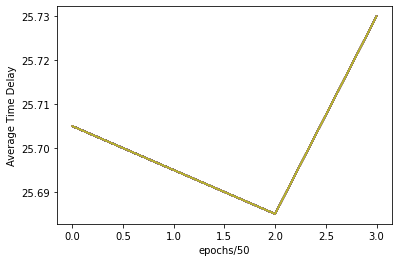

In [ ]:
for i in range(MAX_EPISODES):
    env.reset_ue()
    env.reset_uav()
    state = env.state
    episode_reward = 0
    done = False
    step = 0

    while done == False and step < MAX_EP_STEPS:
        action = policy_net.get_action(state).detach()
        # a = np.clip(np.random.normal(a, var), *a_bound)
        next_state, reward, done, b = env.step(action.numpy(), step)
        
        if b == True and count%10 != 0:
            continue
        else:
            replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        step += 1
        
        if len(replay_buffer) > batch_size:
            # print('learning')
            update(batch_size)

    print(i)
    # print(i, rewards)
    average_delay.append(env.end_time.mean())
    rewards.append(episode_reward)
    plotAvg(i, average_delay)

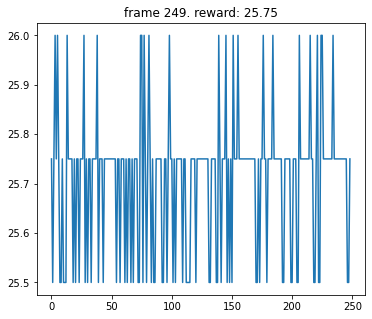

In [ ]:
plot(i, average_delay)